In [49]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd
file_ex = "png"
path = '/data/ij/Mosaic_data_augmentation_YOLO/logitech'
# path = '/data/ij/Mosaic_data_augmentation_YOLO/images'
save_img_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/images/train2017'
save_label_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/labels/train2017'
save_annotations_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/annotations/instances_train2017.json'

im_files = np.array([i for i in os.listdir(path) if i.endswith(file_ex)], dtype = "object")
im_files = list(path + "/" + im_files)

In [50]:
im_f_size = len(im_files)

img_list = []
for div in range(4, im_f_size, 4) :

    img_list.append(im_files[div-4:div])

img_list.append(im_files[len(img_list) * 4:])

In [51]:
def myLoadImage(im_path,img_size, resize=True, augment=True) :
    im = cv2.imread(im_path)
    print(im.shape)
    h0, w0 = im.shape[:2]
    if resize : 
        r = img_size / max(h0, w0)
        if r != 1:  # if sizes are not equal
            interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)
    return im, (h0, w0), im.shape[:2] 

from PIL import Image, ImageDraw
import matplotlib.patches as patches
def myFig(img, bbox_list, drawB = True) :
    image = Image.fromarray(img,"RGB")
    draw = ImageDraw.Draw(image)

    if drawB :
        for bbox in bbox_list : 
            for i in range(len(bbox)) :
                xmin = bbox[i][1] 
                ymin = bbox[i][2]
                xmax = bbox[i][3]
                ymax = bbox[i][4]

                draw.rectangle((xmin, ymin, xmax, ymax), outline=(255,0,0), width = 1) # bounding box
#     display(image)
    return image
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y

def convert_coordinates(x1, y1, x2, y2, img_width, img_height, cate):
    # 바운딩 박스의 중심 좌표와 너비, 높이 계산
    box_width = x2 - x1
    box_height = y2 - y1
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    
    # 이미지의 너비와 높이로 나누어서 정규화된 값 계산
    x_center /= img_width
    y_center /= img_height
    box_width /= img_width
    box_height /= img_height
    
    # 결과를 문자열로 반환
    return f"{cate} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"

In [52]:
img_size = 256
id_cnt = 1
category_id = 1
for i, imgs in enumerate(img_list) : 
    result_img = {}
    for idx , img_path in enumerate(imgs) : 
        img, (h0, w0), (h, w) = myLoadImage(img_path,img_size)

        color = random.randrange(0,255)
#         back_ground = np.full((img_size * 2, img_size * 2, img.shape[2]), color, dtype=np.uint8) 
#         mosaic_border = [img_size // 2, img_size // 2]

#         yc, xc = (int(random.uniform(img_size, 2 *img_size)) for x in mosaic_border) 
        back_ground = np.full((img_size * 2, img_size * 2, img.shape[2]), color, dtype=np.uint8) 
        mosaic_border = [img_size // 2, img_size // 2]

        yc, xc = (int(random.uniform(img_size, 2 *img_size)) for x in mosaic_border) 

        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        xmin, ymin = x1a, y1a

        if int(x2a - x1a)  < img_size : 
            print(f'size ERROR')
        if int(y2a - y1a)  < img_size : 
            print(f'size ERROR')
        back_ground[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        
        padw = x1a - x1b
        padh = y1a - y1b
        
        label = np.array([[0. , 0.5 ,0.5 ,1. , 1. ]])

        if label.size:
            label[:, 1:] = xywhn2xyxy(label[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            label[label < 0] = 0
            label[label > img_size*2] = img_size*2
    break


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


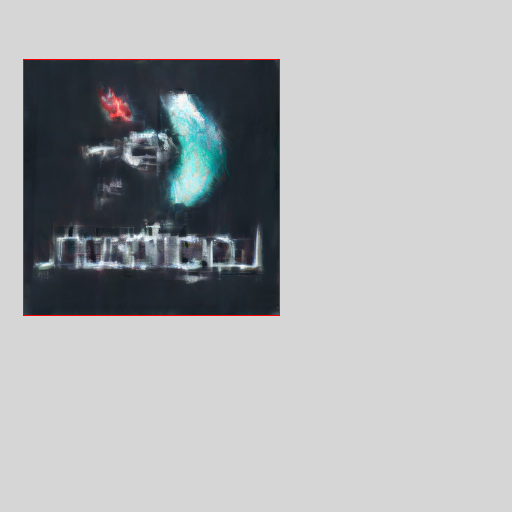

In [53]:
myFig(cv2.cvtColor(back_ground, cv2.COLOR_BGR2RGB), [label])

In [39]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd
file_ex = "png"
# path = '/data/ij/Mosaic_data_augmentation_YOLO/logitech'
path = '/data/ij/Mosaic_data_augmentation_YOLO/images'
save_img_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/images/train2017'
save_label_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/labels/train2017'
save_annotations_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/annotations/instances_train2017.json'

im_files = np.array([i for i in os.listdir(path) if i.endswith(file_ex)], dtype = "object")
im_files = list(path + "/" + im_files)
im_f_size = len(im_files)

img_list = []
for div in range(4, im_f_size, 4) :

    img_list.append(im_files[div-4:div])

img_list.append(im_files[len(img_list) * 4:])

In [47]:
def myLoadImage(im_path,img_size, resize=True, augment=True) :
    im = cv2.imread(im_path)

    h0, w0 = im.shape[:2]
    if resize : 
        r = img_size / max(h0, w0)
        if r != 1:  # if sizes are not equal
            interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
            im = cv2.resize(im, (256, 256), interpolation=interp)
#     return im, (h0, w0), im.shape[:2] 
    return im, (h0, w0), im.shape[:2] 

img_size = 256
id_cnt = 1
category_id = 1
for i, imgs in enumerate(img_list) : 
    result_img = {}
    for idx , img_path in enumerate(imgs) : 
        img, (h0, w0), (h, w) = myLoadImage(img_path,img_size)
        print(img.shape)
        print(h0, w0)
        print(h, w)

        color = random.randrange(0,255)
        back_ground2 = np.full((img_size * 2, img_size * 2, img.shape[2]), color, dtype=np.uint8) 
        mosaic_border = [img_size // 2, img_size // 2]

        yc, xc = (int(random.uniform(img_size, 2 *img_size)) for x in mosaic_border)  

        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        xmin, ymin = x1a, y1a

        if int(x2a - x1a)  < img_size : 
            print(f'size ERROR')
        if int(y2a - y1a)  < img_size : 
            print(f'size ERROR')
        back_ground2[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        
        padw = x1a - x1b
        padh = y1a - y1b
        
        label2 = np.array([[0. , 0.5 ,0.5 ,1. , 1. ]])

        if label2.size:
            label2[:, 1:] = xywhn2xyxy(label2[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            label2[label2 < 0] = 0
            label2[label2 > img_size*2] = img_size*2
    break


(256, 256, 3)
64 64
256 256
(256, 256, 3)
64 64
256 256
(256, 256, 3)
64 64
256 256
(256, 256, 3)
64 64
256 256


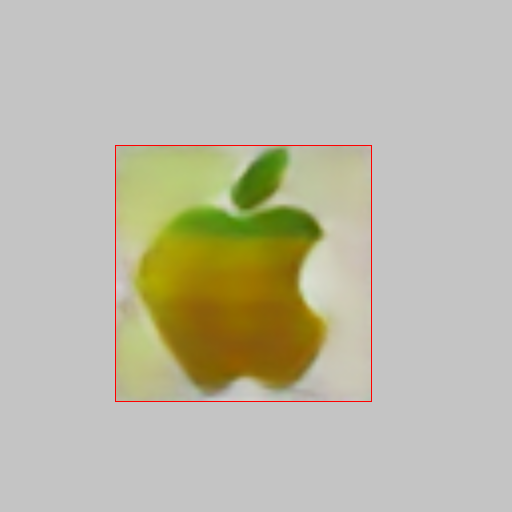

In [48]:
myFig(cv2.cvtColor(back_ground2, cv2.COLOR_BGR2RGB), [label2])

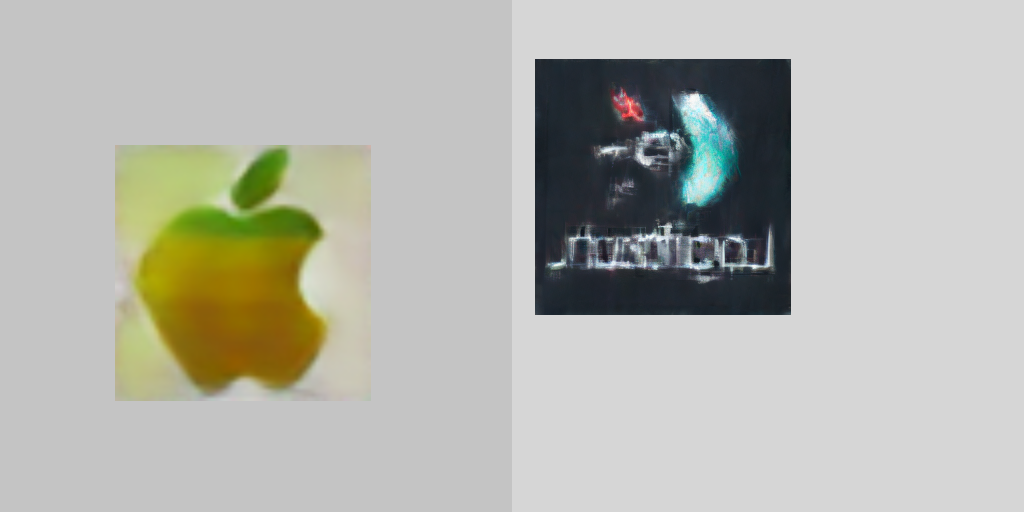

In [66]:

res_img1 = np.concatenate((back_ground2,back_ground),axis=1)
myFig(cv2.cvtColor(res_img1, cv2.COLOR_BGR2RGB), [])           

In [58]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd
file_ex = "png"
path_2 = '/data/ij/Mosaic_data_augmentation_YOLO/logitech'
path_1 = '/data/ij/Mosaic_data_augmentation_YOLO/images'
save_img_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/images/train2017'
save_label_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/labels/train2017'
save_annotations_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_cp/annotations/instances_train2017.json'

im_files_1 = np.array([i for i in os.listdir(path_1) if i.endswith(file_ex)], dtype = "object")
im_files_1 = list(path_1 + "/" + im_files_1)



im_files_2 = np.array([i for i in os.listdir(path_2) if i.endswith(file_ex)], dtype = "object")
im_files_2 = list(path_2 + "/" + im_files_2)


# img_list = []
# for div in range(4, im_f_size, 4) :

#     img_list.append(im_files[div-4:div])

# img_list.append(im_files[len(img_list) * 4:])

In [91]:
max(len(im_files_2),len(im_files_1))
max_file = int(max(len(im_files_2),len(im_files_1)))
min_file = int(min(len(im_files_2),len(im_files_1)))

In [92]:
img_list = []
for idx in range(2, 2002,2):
    if idx < min_file : 
        a = im_files_2[idx-2:idx] + im_files_1[idx-2:idx]
        img_list.append(a)
    else :
        new_idx= random.randrange(0,min_file)
        a = im_files_2[new_idx-2:new_idx] + im_files_1[new_idx-2:new_idx]
        img_list.append(a)


In [93]:
img_list

[['/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_573.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_473.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_573.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_817.png'],
 ['/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_287.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_327.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_287.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_592.png'],
 ['/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_541.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_393.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_62.png',
  '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_541.png'],
 ['/data/ij/Mosaic_data_augmentation_YOLO/logitech/generated_image_559.png',
  '/data/

In [94]:
len(img_list)

1000

In [78]:
color = random.randrange(0,min_file)

In [139]:
def myLoadImage(im_path,img_size, resize=True, augment=True) :
    im = cv2.imread(im_path)
    print(im.shape)
    h0, w0 = im.shape[:2]
    if resize : 
        r = img_size / max(h0, w0)
        if r != 1:  # if sizes are not equal
            interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)
    return im, (h0, w0), im.shape[:2] 

from PIL import Image, ImageDraw
import matplotlib.patches as patches
def myFig(img, bbox_list, drawB = True) :
    image = Image.fromarray(img,"RGB")
    draw = ImageDraw.Draw(image)

    if drawB :
        for bbox in bbox_list : 
            for i in range(len(bbox)) :
                xmin = bbox[i][1] 
                ymin = bbox[i][2]
                xmax = bbox[i][3]
                ymax = bbox[i][4]

                draw.rectangle((xmin, ymin, xmax, ymax), outline=(255,0,0), width = 1) # bounding box
#     display(image)
    return image
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y

def convert_coordinates(x1, y1, x2, y2, img_width, img_height, cate):
    # 바운딩 박스의 중심 좌표와 너비, 높이 계산
    box_width = x2 - x1
    box_height = y2 - y1
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    
    # 이미지의 너비와 높이로 나누어서 정규화된 값 계산
    x_center /= img_width
    y_center /= img_height
    box_width /= img_width
    box_height /= img_height
    
    # 결과를 문자열로 반환
    return f"{cate} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"

In [140]:
#폴더만들기
import os
import shutil
def make_dir(path):
    if not os.path.exists(path):
        print(path)
        make_dir(os.path.dirname(path))
        os.makedirs(path, exist_ok=True)

        
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd
file_ex = "png"
ori_img_path_2 = '/data/ij/Mosaic_data_augmentation_YOLO/logitech'
ori_img_path_1 = '/data/ij/Mosaic_data_augmentation_YOLO/apple'
        
root_path = '/data/ij/Mosaic_data_augmentation_YOLO/coco_ps'
shutil.rmtree(root_path)

save_img_path = f'{root_path}/images/train2017'
save_img_path_val = f'{root_path}/images/val2017'

save_label_path = f'{root_path}/labels/train2017'
save_label_path_val = f'{root_path}/labels/val2017'
save_annotations_path = f'{root_path}/annotations/'
save_annotations_train = f'{root_path}/annotations/instances_train2017.json'
save_annotations_val = f'{root_path}/annotations/instances_val2017.json'

save_path_list = [save_img_path,save_img_path_val,save_label_path,save_label_path_val,save_annotations_path]

for save_path in save_path_list : 
    make_dir(save_path)


/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/images/train2017
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/images
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/images/val2017
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/labels/train2017
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/labels
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/labels/val2017
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/annotations/
/data/ij/Mosaic_data_augmentation_YOLO/coco_ps/annotations


In [141]:
#이미지 패스 불러오기
im_files_1 = np.array([i for i in os.listdir(ori_img_path_1) if i.endswith(file_ex)], dtype = "object")
im_files_1 = list(ori_img_path_1 + "/" + im_files_1)

im_files_2 = np.array([i for i in os.listdir(ori_img_path_2) if i.endswith(file_ex)], dtype = "object")
im_files_2 = list(ori_img_path_2 + "/" + im_files_2)

max(len(im_files_2),len(im_files_1))
max_file = int(max(len(im_files_2),len(im_files_1)))
min_file = int(min(len(im_files_2),len(im_files_1)))
img_list = []
for idx in range(2, 2002,2):
    if idx < min_file : 
        a = im_files_2[idx-2:idx] + im_files_1[idx-2:idx]
        img_list.append(a)
    else :
        new_idx= random.randrange(0,min_file-2)
        a = im_files_2[new_idx-2:new_idx] + im_files_1[new_idx-2:new_idx]
        img_list.append(a)
        

In [142]:
def make_json():
    coco_json_train = {}
    coco_json_train['licenses'] = [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/','id': 1,'name': 'Attribution-NonCommercial-ShareAlike License'}]
    coco_json_train['info'] = {'description': 'COCO apple Dataset','url': '','version': '','year': 2023,'contributor': 'COCO Consortium','date_created': '2023/04/11'}
    coco_json_train['annotations'] = []
    coco_json_train['categories'] = [{'supercategory': 'logitech', 'id': 1, 'name': 'logitech'},{'supercategory': 'apple', 'id': 2, 'name': 'apple'}]
    coco_json_train['images'] = []


    coco_json_val = {}
    coco_json_val['licenses'] = [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/','id': 1,'name': 'Attribution-NonCommercial-ShareAlike License'}]
    coco_json_val['info'] = {'description': 'COCO apple Dataset','url': '','version': '','year': 2023,'contributor': 'COCO Consortium','date_created': '2023/04/11'}
    coco_json_val['annotations'] = []
    coco_json_val['categories'] = [{'supercategory': 'logitech', 'id': 1, 'name': 'logitech'},{'supercategory': 'apple', 'id': 2, 'name': 'apple'}]
    coco_json_val['images'] = []
    return coco_json_train, coco_json_val
coco_json_train, coco_json_val = make_json()

In [143]:
img_size = 256


def test(img_list, save_img_path, save_label_path, save_annotations_path,coco_json,id_cnt,t):
    
    for i, imgs in enumerate(img_list) : 
        result_img = {}
        if len(imgs) <3 :
            continue
        for idx , img_path in enumerate(imgs) : 
            
            if 'logitech' in img_path : 
                category_id = 1
            else :
                category_id = 2
            img, (h0, w0), (h, w) = myLoadImage(img_path,img_size)

            color = random.randrange(0,255)
            back_ground = np.full((img_size * 2, img_size * 2, img.shape[2]), color, dtype=np.uint8) 
            mosaic_border = [img_size // 2, img_size // 2]

            yc, xc = (int(random.uniform(img_size, 2 *img_size)) for x in mosaic_border)  

            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            xmin, ymin = x1a, y1a

            if int(x2a - x1a)  < img_size : 
                print(f'size ERROR')
            if int(y2a - y1a)  < img_size : 
                print(f'size ERROR')
            back_ground[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

            padw = x1a - x1b
            padh = y1a - y1b

            label = np.array([[0. , 0.5 ,0.5 ,1. , 1. ]])

            if label.size:
                label[:, 1:] = xywhn2xyxy(label[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
                label[label < 0] = 0
                label[label > img_size*2] = img_size*2

            if idx == 0 : 
                pass
            elif idx == 1 :
                label[0][1] += img_size * 2
                label[0][3] += img_size * 2
            elif idx == 2 :
                label[0][2] += img_size * 2
                label[0][4] += img_size * 2
            elif idx == 3 :
                label[0][1] += img_size * 2
                label[0][2] += img_size * 2
                label[0][3] += img_size * 2
                label[0][4] += img_size * 2

            result_img[idx] = {'img' : back_ground, 'label':label, 'category_id':category_id}

        if len(result_img) ==4 : 

            res_img1 = np.concatenate((result_img[0]['img'],result_img[1]['img']),axis=1)
            res_img2 = np.concatenate((result_img[2]['img'],result_img[3]['img']),axis=1)
            result_image = np.concatenate((res_img1,res_img2),axis=0)
            label_list = [result_img[idx]['label'] for idx in result_img ]
        else :
            print(imgs)
            print(len(result_img))
            result_image = np.concatenate((result_img[0]['img'],result_img[1]['img']),axis=1)
            label_list = [result_img[idx]['label'] for idx in result_img ]

        cv2.imwrite(f'{save_img_path}/{i+t}.jpg',result_image)
        height, width, _ = result_image.shape

        img_res = {'license': 1, 'file_name': f'{i+t}.jpg','coco_url': '','height': height,'width': width,'date_captured': '','flickr_url': '','id': i+t}

        coco_json['images'].append(img_res)

        with open(f'{save_label_path}/{i+t}.txt', "w") as f:
            for idx in result_img : 
                label = result_img[idx]['label'][0]
                category_id = result_img[idx]['category_id']

                x1, y1, x2, y2 = label[1],label[2],label[3],label[4]

                yolo_bbox = convert_coordinates(x1, y1, x2, y2, width, height, category_id)
                f.write(f"{yolo_bbox}\n")

                coco_bbox = [x1, y1, x2 - x1, y2 - y1]  # COCO bbox 형식으로 변환

                area = coco_bbox[2] * coco_bbox[3]
                res = {'segmentation':[] ,'area': area ,'iscrowd': 0,'image_id': i+t,'bbox': coco_bbox ,'category_id': category_id,'id': id_cnt}
                coco_json['annotations'].append(res)
                id_cnt += 1
                print(res)


    import json
    with open(save_annotations_path, "w") as f:
        json.dump(coco_json, f)
    return id_cnt



In [144]:
split = int(len(img_list) * 0.8)
train_img_list = img_list[:split]
val_img_list = img_list[split:]

id_cnt = 1
t = 0
id_cnt= test(train_img_list, save_img_path, save_label_path, save_annotations_train,coco_json_train, id_cnt,t)
t = int(len(train_img_list))
id_cnt= test(val_img_list, save_img_path_val, save_label_path_val, save_annotations_val,coco_json_val, id_cnt,t)


(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 0, 'bbox': [85.0, 17.0, 256.0, 256.0], 'category_id': 1, 'id': 1}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 0, 'bbox': [578.0, 21.0, 256.0, 256.0], 'category_id': 1, 'id': 2}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 0, 'bbox': [241.0, 604.0, 256.0, 256.0], 'category_id': 2, 'id': 3}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 0, 'bbox': [532.0, 663.0, 256.0, 256.0], 'category_id': 2, 'id': 4}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 1, 'bbox': [212.0, 176.0, 256.0, 256.0], 'category_id': 1, 'id': 5}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 1, 'bbox': [517.0, 75.0, 256.0, 256.0], 'category_id': 1, 'id': 6}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 1, 'bbox': [127.0, 727.0, 256.0, 256.0], 'ca

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 16, 'bbox': [235.0, 133.0, 256.0, 256.0], 'category_id': 1, 'id': 65}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 16, 'bbox': [643.0, 184.0, 256.0, 256.0], 'category_id': 1, 'id': 66}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 16, 'bbox': [15.0, 711.0, 256.0, 256.0], 'category_id': 2, 'id': 67}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 16, 'bbox': [759.0, 604.0, 256.0, 256.0], 'category_id': 2, 'id': 68}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 17, 'bbox': [133.0, 67.0, 256.0, 256.0], 'category_id': 1, 'id': 69}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 17, 'bbox': [733.0, 124.0, 256.0, 256.0], 'category_id': 1, 'id': 70}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 17, 'bbox': [31.0, 701.0, 256.0, 256.0], 'category_id': 2, 'id': 71}
{'segmentatio

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 34, 'bbox': [18.0, 45.0, 256.0, 256.0], 'category_id': 1, 'id': 137}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 34, 'bbox': [709.0, 249.0, 256.0, 256.0], 'category_id': 1, 'id': 138}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 34, 'bbox': [122.0, 693.0, 256.0, 256.0], 'category_id': 2, 'id': 139}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 34, 'bbox': [647.0, 530.0, 256.0, 256.0], 'category_id': 2, 'id': 140}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 35, 'bbox': [82.0, 29.0, 256.0, 256.0], 'category_id': 1, 'id': 141}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 35, 'bbox': [672.0, 45.0, 256.0, 256.0], 'category_id': 1, 'id': 142}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 35, 'bbox': [30.0, 697.0, 256.0, 256.0], 'category_id': 2, 'id': 143}
{'segment

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 50, 'bbox': [12.0, 253.0, 256.0, 256.0], 'category_id': 1, 'id': 201}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 50, 'bbox': [760.0, 108.0, 256.0, 256.0], 'category_id': 1, 'id': 202}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 50, 'bbox': [231.0, 720.0, 256.0, 256.0], 'category_id': 2, 'id': 203}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 50, 'bbox': [547.0, 604.0, 256.0, 256.0], 'category_id': 2, 'id': 204}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 51, 'bbox': [209.0, 92.0, 256.0, 256.0], 'category_id': 1, 'id': 205}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 51, 'bbox': [744.0, 222.0, 256.0, 256.0], 'category_id': 1, 'id': 206}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 51, 'bbox': [92.0, 698.0, 256.0, 256.0], 'category_id': 2, 'id': 207}
{'segm

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 68, 'bbox': [5.0, 113.0, 256.0, 256.0], 'category_id': 1, 'id': 273}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 68, 'bbox': [620.0, 5.0, 256.0, 256.0], 'category_id': 1, 'id': 274}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 68, 'bbox': [70.0, 551.0, 256.0, 256.0], 'category_id': 2, 'id': 275}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 68, 'bbox': [565.0, 559.0, 256.0, 256.0], 'category_id': 2, 'id': 276}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 69, 'bbox': [34.0, 89.0, 256.0, 256.0], 'category_id': 1, 'id': 277}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 69, 'bbox': [651.0, 168.0, 256.0, 256.0], 'category_id': 1, 'id': 278}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 69, 'bbox': [154.0, 648.0, 256.0, 256.0], 'category_id': 2, 'id': 279}
{'segmenta

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 86, 'bbox': [168.0, 220.0, 256.0, 256.0], 'category_id': 1, 'id': 345}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 86, 'bbox': [693.0, 160.0, 256.0, 256.0], 'category_id': 1, 'id': 346}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 86, 'bbox': [63.0, 729.0, 256.0, 256.0], 'category_id': 2, 'id': 347}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 86, 'bbox': [577.0, 597.0, 256.0, 256.0], 'category_id': 2, 'id': 348}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 87, 'bbox': [135.0, 65.0, 256.0, 256.0], 'category_id': 1, 'id': 349}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 87, 'bbox': [518.0, 221.0, 256.0, 256.0], 'category_id': 1, 'id': 350}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 87, 'bbox': [172.0, 732.0, 256.0, 256.0], 'category_id': 2, 'id': 351}
{'seg

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 105, 'bbox': [166.0, 200.0, 256.0, 256.0], 'category_id': 1, 'id': 421}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 105, 'bbox': [707.0, 83.0, 256.0, 256.0], 'category_id': 1, 'id': 422}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 105, 'bbox': [59.0, 553.0, 256.0, 256.0], 'category_id': 2, 'id': 423}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 105, 'bbox': [610.0, 631.0, 256.0, 256.0], 'category_id': 2, 'id': 424}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 106, 'bbox': [120.0, 221.0, 256.0, 256.0], 'category_id': 1, 'id': 425}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 106, 'bbox': [565.0, 179.0, 256.0, 256.0], 'category_id': 1, 'id': 426}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 106, 'bbox': [107.0, 602.0, 256.0, 256.0], 'category_id': 2, 'id': 427

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 119, 'bbox': [234.0, 70.0, 256.0, 256.0], 'category_id': 1, 'id': 477}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 119, 'bbox': [601.0, 66.0, 256.0, 256.0], 'category_id': 1, 'id': 478}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 119, 'bbox': [121.0, 626.0, 256.0, 256.0], 'category_id': 2, 'id': 479}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 119, 'bbox': [523.0, 721.0, 256.0, 256.0], 'category_id': 2, 'id': 480}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 120, 'bbox': [247.0, 214.0, 256.0, 256.0], 'category_id': 1, 'id': 481}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 120, 'bbox': [566.0, 255.0, 256.0, 256.0], 'category_id': 1, 'id': 482}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 120, 'bbox': [72.0, 706.0, 256.0, 256.0], 'category_id': 2, 'id': 483}

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 138, 'bbox': [137.0, 163.0, 256.0, 256.0], 'category_id': 1, 'id': 553}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 138, 'bbox': [513.0, 2.0, 256.0, 256.0], 'category_id': 1, 'id': 554}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 138, 'bbox': [208.0, 692.0, 256.0, 256.0], 'category_id': 2, 'id': 555}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 138, 'bbox': [707.0, 710.0, 256.0, 256.0], 'category_id': 2, 'id': 556}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 139, 'bbox': [110.0, 94.0, 256.0, 256.0], 'category_id': 1, 'id': 557}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 139, 'bbox': [674.0, 125.0, 256.0, 256.0], 'category_id': 1, 'id': 558}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 139, 'bbox': [142.0, 626.0, 256.0, 256.0], 'category_id': 2, 'id': 559}

(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 158, 'bbox': [66.0, 187.0, 256.0, 256.0], 'category_id': 1, 'id': 633}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 158, 'bbox': [539.0, 35.0, 256.0, 256.0], 'category_id': 1, 'id': 634}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 158, 'bbox': [50.0, 718.0, 256.0, 256.0], 'category_id': 2, 'id': 635}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 158, 'bbox': [765.0, 621.0, 256.0, 256.0], 'category_id': 2, 'id': 636}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 159, 'bbox': [174.0, 183.0, 256.0, 256.0], 'category_id': 1, 'id': 637}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 159, 'bbox': [630.0, 50.0, 256.0, 256.0], 'category_id': 1, 'id': 638}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 159, 'bbox': [210.0, 628.0, 256.0, 256.0], 'category_id': 2,

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 176, 'bbox': [153.0, 42.0, 256.0, 256.0], 'category_id': 1, 'id': 705}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 176, 'bbox': [679.0, 144.0, 256.0, 256.0], 'category_id': 1, 'id': 706}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 176, 'bbox': [187.0, 718.0, 256.0, 256.0], 'category_id': 2, 'id': 707}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 176, 'bbox': [575.0, 739.0, 256.0, 256.0], 'category_id': 2, 'id': 708}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 177, 'bbox': [165.0, 62.0, 256.0, 256.0], 'category_id': 1, 'id': 709}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 177, 'bbox': [760.0, 161.0, 256.0, 256.0], 'category_id': 1, 'id': 710}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 177, 'bbox': [126.0, 546.0, 256.0, 256.0], 'category_id': 2, 'id': 711

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 195, 'bbox': [24.0, 159.0, 256.0, 256.0], 'category_id': 1, 'id': 781}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 195, 'bbox': [638.0, 146.0, 256.0, 256.0], 'category_id': 1, 'id': 782}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 195, 'bbox': [174.0, 733.0, 256.0, 256.0], 'category_id': 2, 'id': 783}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 195, 'bbox': [654.0, 512.0, 256.0, 256.0], 'category_id': 2, 'id': 784}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 196, 'bbox': [85.0, 60.0, 256.0, 256.0], 'category_id': 1, 'id': 785}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 196, 'bbox': [573.0, 152.0, 256.0, 256.0], 'category_id': 1, 'id': 786}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 196, 'bbox': [86.0, 659.0, 256.0, 256.0], 'category_id': 2, 'id': 787}


{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 215, 'bbox': [55.0, 220.0, 256.0, 256.0], 'category_id': 1, 'id': 861}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 215, 'bbox': [675.0, 18.0, 256.0, 256.0], 'category_id': 1, 'id': 862}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 215, 'bbox': [204.0, 609.0, 256.0, 256.0], 'category_id': 2, 'id': 863}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 215, 'bbox': [756.0, 695.0, 256.0, 256.0], 'category_id': 2, 'id': 864}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 216, 'bbox': [75.0, 124.0, 256.0, 256.0], 'category_id': 1, 'id': 865}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 216, 'bbox': [561.0, 93.0, 256.0, 256.0], 'category_id': 1, 'id': 866}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 216, 'bbox': [184.0, 744.0, 256.0, 256.0], 'category_id': 2, 'id': 867}


{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 234, 'bbox': [65.0, 160.0, 256.0, 256.0], 'category_id': 1, 'id': 937}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 234, 'bbox': [744.0, 87.0, 256.0, 256.0], 'category_id': 1, 'id': 938}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 234, 'bbox': [207.0, 534.0, 256.0, 256.0], 'category_id': 2, 'id': 939}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 234, 'bbox': [573.0, 563.0, 256.0, 256.0], 'category_id': 2, 'id': 940}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 235, 'bbox': [236.0, 255.0, 256.0, 256.0], 'category_id': 1, 'id': 941}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 235, 'bbox': [526.0, 241.0, 256.0, 256.0], 'category_id': 1, 'id': 942}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 235, 'bbox': [109.0, 742.0, 256.0, 256.0], 'category_id': 2, 'id': 943

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 248, 'bbox': [246.0, 23.0, 256.0, 256.0], 'category_id': 1, 'id': 993}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 248, 'bbox': [544.0, 154.0, 256.0, 256.0], 'category_id': 1, 'id': 994}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 248, 'bbox': [116.0, 578.0, 256.0, 256.0], 'category_id': 2, 'id': 995}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 248, 'bbox': [581.0, 522.0, 256.0, 256.0], 'category_id': 2, 'id': 996}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 249, 'bbox': [104.0, 25.0, 256.0, 256.0], 'category_id': 1, 'id': 997}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 249, 'bbox': [673.0, 176.0, 256.0, 256.0], 'category_id': 1, 'id': 998}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 249, 'bbox': [171.0, 737.0, 256.0, 256.0], 'category_id': 2, 'id': 999

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 262, 'bbox': [74.0, 110.0, 256.0, 256.0], 'category_id': 1, 'id': 1049}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 262, 'bbox': [705.0, 43.0, 256.0, 256.0], 'category_id': 1, 'id': 1050}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 262, 'bbox': [243.0, 603.0, 256.0, 256.0], 'category_id': 2, 'id': 1051}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 262, 'bbox': [703.0, 564.0, 256.0, 256.0], 'category_id': 2, 'id': 1052}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 263, 'bbox': [78.0, 143.0, 256.0, 256.0], 'category_id': 1, 'id': 1053}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 263, 'bbox': [734.0, 97.0, 256.0, 256.0], 'category_id': 1, 'id': 1054}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 263, 'bbox': [133.0, 717.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 281, 'bbox': [230.0, 250.0, 256.0, 256.0], 'category_id': 1, 'id': 1125}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 281, 'bbox': [744.0, 248.0, 256.0, 256.0], 'category_id': 1, 'id': 1126}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 281, 'bbox': [167.0, 689.0, 256.0, 256.0], 'category_id': 2, 'id': 1127}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 281, 'bbox': [560.0, 658.0, 256.0, 256.0], 'category_id': 2, 'id': 1128}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 282, 'bbox': [74.0, 140.0, 256.0, 256.0], 'category_id': 1, 'id': 1129}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 282, 'bbox': [646.0, 228.0, 256.0, 256.0], 'category_id': 1, 'id': 1130}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 282, 'bbox': [254.0, 703.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 295, 'bbox': [119.0, 106.0, 256.0, 256.0], 'category_id': 1, 'id': 1181}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 295, 'bbox': [560.0, 70.0, 256.0, 256.0], 'category_id': 1, 'id': 1182}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 295, 'bbox': [134.0, 519.0, 256.0, 256.0], 'category_id': 2, 'id': 1183}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 295, 'bbox': [694.0, 714.0, 256.0, 256.0], 'category_id': 2, 'id': 1184}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 296, 'bbox': [230.0, 221.0, 256.0, 256.0], 'category_id': 1, 'id': 1185}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 296, 'bbox': [742.0, 195.0, 256.0, 256.0], 'category_id': 1, 'id': 1186}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 296, 'bbox': [151.0, 679.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 309, 'bbox': [153.0, 41.0, 256.0, 256.0], 'category_id': 1, 'id': 1237}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 309, 'bbox': [666.0, 117.0, 256.0, 256.0], 'category_id': 1, 'id': 1238}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 309, 'bbox': [196.0, 724.0, 256.0, 256.0], 'category_id': 2, 'id': 1239}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 309, 'bbox': [640.0, 639.0, 256.0, 256.0], 'category_id': 2, 'id': 1240}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 310, 'bbox': [255.0, 196.0, 256.0, 256.0], 'category_id': 1, 'id': 1241}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 310, 'bbox': [690.0, 253.0, 256.0, 256.0], 'category_id': 1, 'id': 1242}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 310, 'bbox': [208.0, 582.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 323, 'bbox': [87.0, 204.0, 256.0, 256.0], 'category_id': 1, 'id': 1293}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 323, 'bbox': [557.0, 15.0, 256.0, 256.0], 'category_id': 1, 'id': 1294}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 323, 'bbox': [48.0, 703.0, 256.0, 256.0], 'category_id': 2, 'id': 1295}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 323, 'bbox': [647.0, 691.0, 256.0, 256.0], 'category_id': 2, 'id': 1296}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 324, 'bbox': [179.0, 189.0, 256.0, 256.0], 'category_id': 1, 'id': 1297}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 324, 'bbox': [568.0, 28.0, 256.0, 256.0], 'category_id': 1, 'id': 1298}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 324, 'bbox': [248.0, 644.0, 256.0, 256.0], 'category_id': 2, 'id':

(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 337, 'bbox': [20.0, 104.0, 256.0, 256.0], 'category_id': 1, 'id': 1349}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 337, 'bbox': [512.0, 126.0, 256.0, 256.0], 'category_id': 1, 'id': 1350}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 337, 'bbox': [105.0, 753.0, 256.0, 256.0], 'category_id': 2, 'id': 1351}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 337, 'bbox': [517.0, 548.0, 256.0, 256.0], 'category_id': 2, 'id': 1352}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 338, 'bbox': [191.0, 52.0, 256.0, 256.0], 'category_id': 1, 'id': 1353}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 338, 'bbox': [657.0, 17.0, 256.0, 256.0], 'category_id': 1, 'id': 1354}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 338, 'bbox': [190.0, 645.0,

(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 356, 'bbox': [233.0, 214.0, 256.0, 256.0], 'category_id': 1, 'id': 1425}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 356, 'bbox': [675.0, 70.0, 256.0, 256.0], 'category_id': 1, 'id': 1426}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 356, 'bbox': [98.0, 719.0, 256.0, 256.0], 'category_id': 2, 'id': 1427}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 356, 'bbox': [754.0, 668.0, 256.0, 256.0], 'category_id': 2, 'id': 1428}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 357, 'bbox': [217.0, 178.0, 256.0, 256.0], 'category_id': 1, 'id': 1429}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 357, 'bbox': [528.0, 102.0, 256.0, 256.0], 'category_id': 1, 'id': 1430}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 357, 'bbox':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 376, 'bbox': [100.0, 221.0, 256.0, 256.0], 'category_id': 1, 'id': 1505}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 376, 'bbox': [620.0, 109.0, 256.0, 256.0], 'category_id': 1, 'id': 1506}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 376, 'bbox': [202.0, 610.0, 256.0, 256.0], 'category_id': 2, 'id': 1507}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 376, 'bbox': [703.0, 564.0, 256.0, 256.0], 'category_id': 2, 'id': 1508}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 377, 'bbox': [214.0, 6.0, 256.0, 256.0], 'category_id': 1, 'id': 1509}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 377, 'bbox': [717.0, 187.0, 256.0, 256.0], 'category_id': 1, 'id': 1510}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 377, 'bbox': [173.0, 678.0, 256.0, 256.0], 'category_id': 2, 'id

(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 391, 'bbox': [48.0, 7.0, 256.0, 256.0], 'category_id': 1, 'id': 1565}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 391, 'bbox': [588.0, 7.0, 256.0, 256.0], 'category_id': 1, 'id': 1566}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 391, 'bbox': [215.0, 616.0, 256.0, 256.0], 'category_id': 2, 'id': 1567}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 391, 'bbox': [737.0, 734.0, 256.0, 256.0], 'category_id': 2, 'id': 1568}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 392, 'bbox': [126.0, 156.0, 256.0, 256.0], 'category_id': 1, 'id': 1569}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 392, 'bbox': [744.0, 26.0, 256.0, 256.0], 'category_id': 1, 'id': 1570}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 392, 'bbox': [50

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 411, 'bbox': [53.0, 34.0, 256.0, 256.0], 'category_id': 1, 'id': 1645}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 411, 'bbox': [649.0, 141.0, 256.0, 256.0], 'category_id': 1, 'id': 1646}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 411, 'bbox': [78.0, 700.0, 256.0, 256.0], 'category_id': 2, 'id': 1647}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 411, 'bbox': [763.0, 625.0, 256.0, 256.0], 'category_id': 2, 'id': 1648}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 412, 'bbox': [69.0, 158.0, 256.0, 256.0], 'category_id': 1, 'id': 1649}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 412, 'bbox': [763.0, 184.0, 256.0, 256.0], 'category_id': 1, 'id': 1650}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 412, 'bbox': [126.0, 708.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 425, 'bbox': [87.0, 96.0, 256.0, 256.0], 'category_id': 1, 'id': 1701}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 425, 'bbox': [535.0, 129.0, 256.0, 256.0], 'category_id': 1, 'id': 1702}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 425, 'bbox': [167.0, 574.0, 256.0, 256.0], 'category_id': 2, 'id': 1703}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 425, 'bbox': [766.0, 583.0, 256.0, 256.0], 'category_id': 2, 'id': 1704}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 426, 'bbox': [18.0, 241.0, 256.0, 256.0], 'category_id': 1, 'id': 1705}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 426, 'bbox': [604.0, 52.0, 256.0, 256.0], 'category_id': 1, 'id': 1706}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 426, 'bbox': [154.0, 750.0, 256.0, 256.0], 'category_id': 2, 'id':

(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 439, 'bbox': [32.0, 210.0, 256.0, 256.0], 'category_id': 1, 'id': 1757}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 439, 'bbox': [562.0, 163.0, 256.0, 256.0], 'category_id': 1, 'id': 1758}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 439, 'bbox': [190.0, 563.0, 256.0, 256.0], 'category_id': 2, 'id': 1759}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 439, 'bbox': [585.0, 541.0, 256.0, 256.0], 'category_id': 2, 'id': 1760}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 440, 'bbox': [116.0, 123.0, 256.0, 256.0], 'category_id': 1, 'id': 1761}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 440, 'bbox': [759.0, 180.0, 256.0, 256.0], 'category_id': 1, 'id': 1762}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 440, 'bbox'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 453, 'bbox': [16.0, 71.0, 256.0, 256.0], 'category_id': 1, 'id': 1813}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 453, 'bbox': [542.0, 65.0, 256.0, 256.0], 'category_id': 1, 'id': 1814}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 453, 'bbox': [114.0, 661.0, 256.0, 256.0], 'category_id': 2, 'id': 1815}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 453, 'bbox': [639.0, 760.0, 256.0, 256.0], 'category_id': 2, 'id': 1816}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 454, 'bbox': [145.0, 180.0, 256.0, 256.0], 'category_id': 1, 'id': 1817}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 454, 'bbox': [690.0, 26.0, 256.0, 256.0], 'category_id': 1, 'id': 1818}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 454, 'bbox': [112.0, 726.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 467, 'bbox': [161.0, 252.0, 256.0, 256.0], 'category_id': 1, 'id': 1869}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 467, 'bbox': [669.0, 186.0, 256.0, 256.0], 'category_id': 1, 'id': 1870}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 467, 'bbox': [108.0, 552.0, 256.0, 256.0], 'category_id': 2, 'id': 1871}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 467, 'bbox': [630.0, 517.0, 256.0, 256.0], 'category_id': 2, 'id': 1872}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 468, 'bbox': [143.0, 102.0, 256.0, 256.0], 'category_id': 1, 'id': 1873}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 468, 'bbox': [755.0, 158.0, 256.0, 256.0], 'category_id': 1, 'id': 1874}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 468, 'bbox': [87.0, 634.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 481, 'bbox': [43.0, 15.0, 256.0, 256.0], 'category_id': 1, 'id': 1925}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 481, 'bbox': [741.0, 222.0, 256.0, 256.0], 'category_id': 1, 'id': 1926}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 481, 'bbox': [254.0, 674.0, 256.0, 256.0], 'category_id': 2, 'id': 1927}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 481, 'bbox': [523.0, 626.0, 256.0, 256.0], 'category_id': 2, 'id': 1928}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 482, 'bbox': [150.0, 215.0, 256.0, 256.0], 'category_id': 1, 'id': 1929}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 482, 'bbox': [623.0, 145.0, 256.0, 256.0], 'category_id': 1, 'id': 1930}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 482, 'bbox': [155.0, 568.0, 256.0, 256.0], 'category_id': 2, 'id

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 501, 'bbox': [153.0, 145.0, 256.0, 256.0], 'category_id': 1, 'id': 2005}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 501, 'bbox': [587.0, 204.0, 256.0, 256.0], 'category_id': 1, 'id': 2006}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 501, 'bbox': [219.0, 611.0, 256.0, 256.0], 'category_id': 2, 'id': 2007}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 501, 'bbox': [708.0, 547.0, 256.0, 256.0], 'category_id': 2, 'id': 2008}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 502, 'bbox': [43.0, 96.0, 256.0, 256.0], 'category_id': 1, 'id': 2009}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 502, 'bbox': [530.0, 24.0, 256.0, 256.0], 'category_id': 1, 'id': 2010}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 502, 'bbox': [135.0, 710.0, 256.0, 256.0], 'category_id': 2, 'id'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 515, 'bbox': [128.0, 134.0, 256.0, 256.0], 'category_id': 1, 'id': 2061}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 515, 'bbox': [679.0, 26.0, 256.0, 256.0], 'category_id': 1, 'id': 2062}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 515, 'bbox': [34.0, 537.0, 256.0, 256.0], 'category_id': 2, 'id': 2063}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 515, 'bbox': [606.0, 633.0, 256.0, 256.0], 'category_id': 2, 'id': 2064}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 516, 'bbox': [250.0, 187.0, 256.0, 256.0], 'category_id': 1, 'id': 2065}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 516, 'bbox': [550.0, 135.0, 256.0, 256.0], 'category_id': 1, 'id': 2066}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 516, 'bbox': [44.0, 616.0, 256.0, 256.0], 'category_id': 2, 'id'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 529, 'bbox': [28.0, 150.0, 256.0, 256.0], 'category_id': 1, 'id': 2117}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 529, 'bbox': [748.0, 123.0, 256.0, 256.0], 'category_id': 1, 'id': 2118}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 529, 'bbox': [216.0, 672.0, 256.0, 256.0], 'category_id': 2, 'id': 2119}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 529, 'bbox': [636.0, 540.0, 256.0, 256.0], 'category_id': 2, 'id': 2120}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 530, 'bbox': [122.0, 212.0, 256.0, 256.0], 'category_id': 1, 'id': 2121}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 530, 'bbox': [548.0, 210.0, 256.0, 256.0], 'category_id': 1, 'id': 2122}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 530, 'bbox': [127.0, 753.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 548, 'bbox': [82.0, 180.0, 256.0, 256.0], 'category_id': 1, 'id': 2193}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 548, 'bbox': [559.0, 218.0, 256.0, 256.0], 'category_id': 1, 'id': 2194}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 548, 'bbox': [68.0, 720.0, 256.0, 256.0], 'category_id': 2, 'id': 2195}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 548, 'bbox': [685.0, 631.0, 256.0, 256.0], 'category_id': 2, 'id': 2196}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 549, 'bbox': [50.0, 196.0, 256.0, 256.0], 'category_id': 1, 'id': 2197}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 549, 'bbox': [534.0, 34.0, 256.0, 256.0], 'category_id': 1, 'id': 2198}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 549, 'bbox': [227.0, 739.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 562, 'bbox': [126.0, 8.0, 256.0, 256.0], 'category_id': 1, 'id': 2249}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 562, 'bbox': [681.0, 1.0, 256.0, 256.0], 'category_id': 1, 'id': 2250}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 562, 'bbox': [158.0, 539.0, 256.0, 256.0], 'category_id': 2, 'id': 2251}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 562, 'bbox': [712.0, 642.0, 256.0, 256.0], 'category_id': 2, 'id': 2252}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 563, 'bbox': [139.0, 168.0, 256.0, 256.0], 'category_id': 1, 'id': 2253}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 563, 'bbox': [513.0, 141.0, 256.0, 256.0], 'category_id': 1, 'id': 2254}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 563, 'bbox': [141.0, 697.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 577, 'bbox': [25.0, 235.0, 256.0, 256.0], 'category_id': 1, 'id': 2305}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 577, 'bbox': [677.0, 210.0, 256.0, 256.0], 'category_id': 1, 'id': 2306}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 577, 'bbox': [109.0, 696.0, 256.0, 256.0], 'category_id': 2, 'id': 2307}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 577, 'bbox': [745.0, 634.0, 256.0, 256.0], 'category_id': 2, 'id': 2308}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 578, 'bbox': [69.0, 36.0, 256.0, 256.0], 'category_id': 1, 'id': 2309}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 578, 'bbox': [525.0, 213.0, 256.0, 256.0], 'category_id': 1, 'id': 2310}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 578, 'bbox': [121.0, 597.0, 256.0, 256.0], 'category_id': 2, 'id'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 591, 'bbox': [227.0, 47.0, 256.0, 256.0], 'category_id': 1, 'id': 2361}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 591, 'bbox': [721.0, 64.0, 256.0, 256.0], 'category_id': 1, 'id': 2362}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 591, 'bbox': [114.0, 517.0, 256.0, 256.0], 'category_id': 2, 'id': 2363}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 591, 'bbox': [737.0, 634.0, 256.0, 256.0], 'category_id': 2, 'id': 2364}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 592, 'bbox': [180.0, 210.0, 256.0, 256.0], 'category_id': 1, 'id': 2365}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 592, 'bbox': [723.0, 189.0, 256.0, 256.0], 'category_id': 1, 'id': 2366}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 592, 'bbox': [247.0, 588.0, 256.0, 256.0], 'category_id': 2, 'id

(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 606, 'bbox': [163.0, 125.0, 256.0, 256.0], 'category_id': 1, 'id': 2421}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 606, 'bbox': [689.0, 189.0, 256.0, 256.0], 'category_id': 1, 'id': 2422}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 606, 'bbox': [253.0, 722.0, 256.0, 256.0], 'category_id': 2, 'id': 2423}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 606, 'bbox': [595.0, 603.0, 256.0, 256.0], 'category_id': 2, 'id': 2424}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 607, 'bbox': [228.0, 31.0, 256.0, 256.0], 'category_id': 1, 'id': 2425}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 607, 'bbox': [756.0, 87.0, 256.0, 256.0], 'category_id': 1, 'id': 2426}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 607, 'bbox': [126.0, 676.0

(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 627, 'bbox': [250.0, 115.0, 256.0, 256.0], 'category_id': 1, 'id': 2497}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 627, 'bbox': [754.0, 132.0, 256.0, 256.0], 'category_id': 1, 'id': 2498}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 627, 'bbox': [146.0, 735.0, 256.0, 256.0], 'category_id': 2, 'id': 2499}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 627, 'bbox': [540.0, 671.0, 256.0, 256.0], 'category_id': 2, 'id': 2500}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 628, 'bbox': [36.0, 131.0, 256.0, 256.0], 'category_id': 1, 'id': 2501}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 628, 'bbox': [758.0, 225.0, 256.0, 256.0], 'category_id': 1, 'id': 2502}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 628, 'bbox': [124.0, 704.

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 646, 'bbox': [197.0, 95.0, 256.0, 256.0], 'category_id': 1, 'id': 2573}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 646, 'bbox': [578.0, 7.0, 256.0, 256.0], 'category_id': 1, 'id': 2574}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 646, 'bbox': [147.0, 695.0, 256.0, 256.0], 'category_id': 2, 'id': 2575}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 646, 'bbox': [762.0, 577.0, 256.0, 256.0], 'category_id': 2, 'id': 2576}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 647, 'bbox': [111.0, 31.0, 256.0, 256.0], 'category_id': 1, 'id': 2577}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 647, 'bbox': [761.0, 235.0, 256.0, 256.0], 'category_id': 1, 'id': 2578}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 647, 'bbox': [116.0, 554.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 660, 'bbox': [224.0, 118.0, 256.0, 256.0], 'category_id': 1, 'id': 2629}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 660, 'bbox': [670.0, 186.0, 256.0, 256.0], 'category_id': 1, 'id': 2630}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 660, 'bbox': [160.0, 618.0, 256.0, 256.0], 'category_id': 2, 'id': 2631}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 660, 'bbox': [695.0, 697.0, 256.0, 256.0], 'category_id': 2, 'id': 2632}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 661, 'bbox': [180.0, 125.0, 256.0, 256.0], 'category_id': 1, 'id': 2633}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 661, 'bbox': [717.0, 183.0, 256.0, 256.0], 'category_id': 1, 'id': 2634}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 661, 'bbox': [21.0, 592.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 680, 'bbox': [82.0, 20.0, 256.0, 256.0], 'category_id': 1, 'id': 2709}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 680, 'bbox': [529.0, 217.0, 256.0, 256.0], 'category_id': 1, 'id': 2710}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 680, 'bbox': [49.0, 613.0, 256.0, 256.0], 'category_id': 2, 'id': 2711}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 680, 'bbox': [523.0, 691.0, 256.0, 256.0], 'category_id': 2, 'id': 2712}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 681, 'bbox': [207.0, 237.0, 256.0, 256.0], 'category_id': 1, 'id': 2713}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 681, 'bbox': [538.0, 166.0, 256.0, 256.0], 'category_id': 1, 'id': 2714}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 681, 'bbox': [15.0, 683.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 694, 'bbox': [62.0, 250.0, 256.0, 256.0], 'category_id': 1, 'id': 2765}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 694, 'bbox': [735.0, 91.0, 256.0, 256.0], 'category_id': 1, 'id': 2766}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 694, 'bbox': [33.0, 641.0, 256.0, 256.0], 'category_id': 2, 'id': 2767}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 694, 'bbox': [640.0, 665.0, 256.0, 256.0], 'category_id': 2, 'id': 2768}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 695, 'bbox': [70.0, 138.0, 256.0, 256.0], 'category_id': 1, 'id': 2769}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 695, 'bbox': [542.0, 105.0, 256.0, 256.0], 'category_id': 1, 'id': 2770}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 695, 'bbox': [4.0, 591.0, 256.0, 256.0], 'category_id': 2, 'id': 2

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 708, 'bbox': [254.0, 112.0, 256.0, 256.0], 'category_id': 1, 'id': 2821}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 708, 'bbox': [616.0, 116.0, 256.0, 256.0], 'category_id': 1, 'id': 2822}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 708, 'bbox': [212.0, 662.0, 256.0, 256.0], 'category_id': 2, 'id': 2823}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 708, 'bbox': [706.0, 568.0, 256.0, 256.0], 'category_id': 2, 'id': 2824}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 709, 'bbox': [209.0, 248.0, 256.0, 256.0], 'category_id': 1, 'id': 2825}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 709, 'bbox': [732.0, 72.0, 256.0, 256.0], 'category_id': 1, 'id': 2826}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 709, 'bbox': [227.0, 707.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 722, 'bbox': [107.0, 89.0, 256.0, 256.0], 'category_id': 1, 'id': 2877}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 722, 'bbox': [610.0, 179.0, 256.0, 256.0], 'category_id': 1, 'id': 2878}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 722, 'bbox': [225.0, 608.0, 256.0, 256.0], 'category_id': 2, 'id': 2879}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 722, 'bbox': [753.0, 596.0, 256.0, 256.0], 'category_id': 2, 'id': 2880}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 723, 'bbox': [109.0, 8.0, 256.0, 256.0], 'category_id': 1, 'id': 2881}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 723, 'bbox': [728.0, 83.0, 256.0, 256.0], 'category_id': 1, 'id': 2882}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 723, 'bbox': [205.0, 560.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 736, 'bbox': [89.0, 240.0, 256.0, 256.0], 'category_id': 1, 'id': 2933}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 736, 'bbox': [516.0, 212.0, 256.0, 256.0], 'category_id': 1, 'id': 2934}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 736, 'bbox': [130.0, 660.0, 256.0, 256.0], 'category_id': 2, 'id': 2935}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 736, 'bbox': [733.0, 586.0, 256.0, 256.0], 'category_id': 2, 'id': 2936}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 737, 'bbox': [232.0, 28.0, 256.0, 256.0], 'category_id': 1, 'id': 2937}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 737, 'bbox': [726.0, 143.0, 256.0, 256.0], 'category_id': 1, 'id': 2938}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 737, 'bbox': [207.0, 742.0, 256.0, 256.0], 'category_id': 2, 'id

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 750, 'bbox': [162.0, 245.0, 256.0, 256.0], 'category_id': 1, 'id': 2989}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 750, 'bbox': [543.0, 56.0, 256.0, 256.0], 'category_id': 1, 'id': 2990}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 750, 'bbox': [158.0, 708.0, 256.0, 256.0], 'category_id': 2, 'id': 2991}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 750, 'bbox': [742.0, 566.0, 256.0, 256.0], 'category_id': 2, 'id': 2992}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 751, 'bbox': [182.0, 46.0, 256.0, 256.0], 'category_id': 1, 'id': 2993}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 751, 'bbox': [686.0, 10.0, 256.0, 256.0], 'category_id': 1, 'id': 2994}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 751, 'bbox': [124.0, 651.0, 256.0, 256.0], 'category_id': 2, 'id'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 764, 'bbox': [46.0, 69.0, 256.0, 256.0], 'category_id': 1, 'id': 3045}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 764, 'bbox': [675.0, 38.0, 256.0, 256.0], 'category_id': 1, 'id': 3046}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 764, 'bbox': [53.0, 583.0, 256.0, 256.0], 'category_id': 2, 'id': 3047}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 764, 'bbox': [757.0, 645.0, 256.0, 256.0], 'category_id': 2, 'id': 3048}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 765, 'bbox': [73.0, 99.0, 256.0, 256.0], 'category_id': 1, 'id': 3049}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 765, 'bbox': [744.0, 135.0, 256.0, 256.0], 'category_id': 1, 'id': 3050}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 765, 'bbox': [195.0, 606.0, 256.0, 256.0], 'category_id': 2, 'id': 3

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 781, 'bbox': [148.0, 245.0, 256.0, 256.0], 'category_id': 1, 'id': 3113}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 781, 'bbox': [736.0, 212.0, 256.0, 256.0], 'category_id': 1, 'id': 3114}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 781, 'bbox': [122.0, 765.0, 256.0, 256.0], 'category_id': 2, 'id': 3115}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 781, 'bbox': [571.0, 554.0, 256.0, 256.0], 'category_id': 2, 'id': 3116}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 782, 'bbox': [171.0, 94.0, 256.0, 256.0], 'category_id': 1, 'id': 3117}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 782, 'bbox': [743.0, 38.0, 256.0, 256.0], 'category_id': 1, 'id': 3118}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 782, 'bbox': [36.0, 668.0, 256.0, 256.0], 'category_id': 2, 'id'

(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 800, 'bbox': [29.0, 251.0, 256.0, 256.0], 'category_id': 1, 'id': 3189}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 800, 'bbox': [637.0, 126.0, 256.0, 256.0], 'category_id': 1, 'id': 3190}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 800, 'bbox': [158.0, 520.0, 256.0, 256.0], 'category_id': 2, 'id': 3191}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 800, 'bbox': [586.0, 626.0, 256.0, 256.0], 'category_id': 2, 'id': 3192}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 801, 'bbox': [178.0, 88.0, 256.0, 256.0], 'category_id': 1, 'id': 3193}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 801, 'bbox': [631.0, 169.0, 256.0, 256.0], 'category_id': 1, 'id': 3194}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 801, 'bbox':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 820, 'bbox': [217.0, 157.0, 256.0, 256.0], 'category_id': 1, 'id': 3269}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 820, 'bbox': [663.0, 243.0, 256.0, 256.0], 'category_id': 1, 'id': 3270}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 820, 'bbox': [94.0, 698.0, 256.0, 256.0], 'category_id': 2, 'id': 3271}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 820, 'bbox': [689.0, 513.0, 256.0, 256.0], 'category_id': 2, 'id': 3272}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 821, 'bbox': [60.0, 206.0, 256.0, 256.0], 'category_id': 1, 'id': 3273}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 821, 'bbox': [707.0, 253.0, 256.0, 256.0], 'category_id': 1, 'id': 3274}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 821, 'bbox': [138.0, 695.0, 256.0, 256.0], 'category_id': 2, 'id

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 834, 'bbox': [96.0, 198.0, 256.0, 256.0], 'category_id': 1, 'id': 3325}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 834, 'bbox': [628.0, 135.0, 256.0, 256.0], 'category_id': 1, 'id': 3326}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 834, 'bbox': [183.0, 734.0, 256.0, 256.0], 'category_id': 2, 'id': 3327}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 834, 'bbox': [690.0, 766.0, 256.0, 256.0], 'category_id': 2, 'id': 3328}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 835, 'bbox': [147.0, 151.0, 256.0, 256.0], 'category_id': 1, 'id': 3329}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 835, 'bbox': [635.0, 161.0, 256.0, 256.0], 'category_id': 1, 'id': 3330}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 835, 'bbox': [192.0, 671.0, 256.0, 256.0], 'category_id': 2, 'i

(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 848, 'bbox': [215.0, 51.0, 256.0, 256.0], 'category_id': 1, 'id': 3381}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 848, 'bbox': [575.0, 151.0, 256.0, 256.0], 'category_id': 1, 'id': 3382}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 848, 'bbox': [109.0, 614.0, 256.0, 256.0], 'category_id': 2, 'id': 3383}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 848, 'bbox': [561.0, 568.0, 256.0, 256.0], 'category_id': 2, 'id': 3384}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 849, 'bbox': [93.0, 219.0, 256.0, 256.0], 'category_id': 1, 'id': 3385}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 849, 'bbox': [666.0, 57.0, 256.0, 256.0], 'category_id': 1, 'id': 3386}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 849, 'bbox': [128.0, 729.0, 256.0, 256.0], 'category_

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 868, 'bbox': [214.0, 130.0, 256.0, 256.0], 'category_id': 1, 'id': 3461}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 868, 'bbox': [610.0, 203.0, 256.0, 256.0], 'category_id': 1, 'id': 3462}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 868, 'bbox': [9.0, 522.0, 256.0, 256.0], 'category_id': 2, 'id': 3463}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 868, 'bbox': [642.0, 695.0, 256.0, 256.0], 'category_id': 2, 'id': 3464}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 869, 'bbox': [120.0, 204.0, 256.0, 256.0], 'category_id': 1, 'id': 3465}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 869, 'bbox': [719.0, 107.0, 256.0, 256.0], 'category_id': 1, 'id': 3466}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 869, 'bbox': [181.0, 707.0, 256.0, 256.0], 'category_id': 2, 'id

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 882, 'bbox': [43.0, 75.0, 256.0, 256.0], 'category_id': 1, 'id': 3517}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 882, 'bbox': [600.0, 122.0, 256.0, 256.0], 'category_id': 1, 'id': 3518}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 882, 'bbox': [28.0, 527.0, 256.0, 256.0], 'category_id': 2, 'id': 3519}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 882, 'bbox': [547.0, 639.0, 256.0, 256.0], 'category_id': 2, 'id': 3520}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 883, 'bbox': [52.0, 81.0, 256.0, 256.0], 'category_id': 1, 'id': 3521}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 883, 'bbox': [660.0, 60.0, 256.0, 256.0], 'category_id': 1, 'id': 3522}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 883, 'bbox': [67.0, 731.0, 256.0, 256.0], 'category_id': 2, 'id': 35

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 902, 'bbox': [125.0, 75.0, 256.0, 256.0], 'category_id': 1, 'id': 3597}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 902, 'bbox': [742.0, 150.0, 256.0, 256.0], 'category_id': 1, 'id': 3598}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 902, 'bbox': [124.0, 594.0, 256.0, 256.0], 'category_id': 2, 'id': 3599}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 902, 'bbox': [627.0, 742.0, 256.0, 256.0], 'category_id': 2, 'id': 3600}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 903, 'bbox': [230.0, 248.0, 256.0, 256.0], 'category_id': 1, 'id': 3601}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 903, 'bbox': [546.0, 125.0, 256.0, 256.0], 'category_id': 1, 'id': 3602}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 903, 'bbox': [79.0, 619.0, 256.0, 256.0], 'category_id': 2, 'id

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 918, 'bbox': [5.0, 57.0, 256.0, 256.0], 'category_id': 1, 'id': 3661}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 918, 'bbox': [574.0, 195.0, 256.0, 256.0], 'category_id': 1, 'id': 3662}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 918, 'bbox': [176.0, 566.0, 256.0, 256.0], 'category_id': 2, 'id': 3663}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 918, 'bbox': [720.0, 649.0, 256.0, 256.0], 'category_id': 2, 'id': 3664}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 919, 'bbox': [126.0, 170.0, 256.0, 256.0], 'category_id': 1, 'id': 3665}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 919, 'bbox': [741.0, 147.0, 256.0, 256.0], 'category_id': 1, 'id': 3666}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 919, 'bbox': [213.0, 564.0, 256.0, 256.0], 'category_id': 2, 'id'

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 932, 'bbox': [192.0, 153.0, 256.0, 256.0], 'category_id': 1, 'id': 3717}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 932, 'bbox': [736.0, 172.0, 256.0, 256.0], 'category_id': 1, 'id': 3718}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 932, 'bbox': [5.0, 637.0, 256.0, 256.0], 'category_id': 2, 'id': 3719}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 932, 'bbox': [681.0, 737.0, 256.0, 256.0], 'category_id': 2, 'id': 3720}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 933, 'bbox': [22.0, 92.0, 256.0, 256.0], 'category_id': 1, 'id': 3721}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 933, 'bbox': [570.0, 184.0, 256.0, 256.0], 'category_id': 1, 'id': 3722}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 933, 'bbox': [104.0, 677.0, 256.0, 256.0], 'category_id': 2, 'id':

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 950, 'bbox': [44.0, 108.0, 256.0, 256.0], 'category_id': 1, 'id': 3789}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 950, 'bbox': [728.0, 160.0, 256.0, 256.0], 'category_id': 1, 'id': 3790}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 950, 'bbox': [150.0, 678.0, 256.0, 256.0], 'category_id': 2, 'id': 3791}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 950, 'bbox': [763.0, 729.0, 256.0, 256.0], 'category_id': 2, 'id': 3792}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 951, 'bbox': [156.0, 239.0, 256.0, 256.0], 'category_id': 1, 'id': 3793}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 951, 'bbox': [633.0, 159.0, 256.0, 256.0], 'category_id': 1, 'id': 3794}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 951, 'bbox': [169.0, 578.0, 256.0, 256.0], 'category_id': 2, 'i

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 964, 'bbox': [172.0, 195.0, 256.0, 256.0], 'category_id': 1, 'id': 3845}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 964, 'bbox': [592.0, 74.0, 256.0, 256.0], 'category_id': 1, 'id': 3846}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 964, 'bbox': [146.0, 639.0, 256.0, 256.0], 'category_id': 2, 'id': 3847}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 964, 'bbox': [612.0, 698.0, 256.0, 256.0], 'category_id': 2, 'id': 3848}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 965, 'bbox': [206.0, 1.0, 256.0, 256.0], 'category_id': 1, 'id': 3849}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 965, 'bbox': [532.0, 87.0, 256.0, 256.0], 'category_id': 1, 'id': 3850}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 965, 'bbox': [44.0, 630.0, 256.0, 256.0], 'category_id': 2, 'id': 

{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 978, 'bbox': [188.0, 173.0, 256.0, 256.0], 'category_id': 1, 'id': 3901}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 978, 'bbox': [656.0, 132.0, 256.0, 256.0], 'category_id': 1, 'id': 3902}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 978, 'bbox': [161.0, 745.0, 256.0, 256.0], 'category_id': 2, 'id': 3903}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 978, 'bbox': [615.0, 640.0, 256.0, 256.0], 'category_id': 2, 'id': 3904}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 979, 'bbox': [66.0, 175.0, 256.0, 256.0], 'category_id': 1, 'id': 3905}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 979, 'bbox': [761.0, 137.0, 256.0, 256.0], 'category_id': 1, 'id': 3906}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 979, 'bbox': [187.0, 654.0, 256.0, 256.0], 'category_id': 2, 'i

(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 992, 'bbox': [176.0, 129.0, 256.0, 256.0], 'category_id': 1, 'id': 3957}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 992, 'bbox': [749.0, 171.0, 256.0, 256.0], 'category_id': 1, 'id': 3958}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 992, 'bbox': [70.0, 709.0, 256.0, 256.0], 'category_id': 2, 'id': 3959}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 992, 'bbox': [725.0, 749.0, 256.0, 256.0], 'category_id': 2, 'id': 3960}
(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 993, 'bbox': [118.0, 102.0, 256.0, 256.0], 'category_id': 1, 'id': 3961}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 993, 'bbox': [618.0, 106.0, 256.0, 256.0], 'category_id': 1, 'id': 3962}
{'segmentation': [], 'area': 65536.0, 'iscrowd': 0, 'image_id': 993, 'bbox': [102.0, 554.0, 256.0, 256.0], 'categor

In [138]:
for i, imgs in enumerate(train_img_list) : 
    if len(imgs) == 0 :
        print(imgs) 
        print(i)
        print('ddd')

[]
240
ddd


In [145]:
result_img

{}

In [146]:
for i, imgs in enumerate(train_img_list) : 
    result_img = {}
    if len(imgs) <3 :
        continue
    for idx , img_path in enumerate(imgs) : 

        if 'logitech' in img_path : 
            category_id = 1
        else :
            category_id = 2
        img, (h0, w0), (h, w) = myLoadImage(img_path,img_size)

        color = random.randrange(0,255)
        back_ground = np.full((img_size * 2, img_size * 2, img.shape[2]), color, dtype=np.uint8) 
        mosaic_border = [img_size // 2, img_size // 2]

        yc, xc = (int(random.uniform(img_size, 2 *img_size)) for x in mosaic_border)  

        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        xmin, ymin = x1a, y1a

        if int(x2a - x1a)  < img_size : 
            print(f'size ERROR')
        if int(y2a - y1a)  < img_size : 
            print(f'size ERROR')
        back_ground[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

        padw = x1a - x1b
        padh = y1a - y1b

        label = np.array([[0. , 0.5 ,0.5 ,1. , 1. ]])

        if label.size:
            label[:, 1:] = xywhn2xyxy(label[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            label[label < 0] = 0
            label[label > img_size*2] = img_size*2

        if idx == 0 : 
            pass
        elif idx == 1 :
            label[0][1] += img_size * 2
            label[0][3] += img_size * 2
        elif idx == 2 :
            label[0][2] += img_size * 2
            label[0][4] += img_size * 2
        elif idx == 3 :
            label[0][1] += img_size * 2
            label[0][2] += img_size * 2
            label[0][3] += img_size * 2
            label[0][4] += img_size * 2

        result_img[idx] = {'img' : back_ground, 'label':label, 'category_id':category_id}

    if len(result_img) ==4 : 

        res_img1 = np.concatenate((result_img[0]['img'],result_img[1]['img']),axis=1)
        res_img2 = np.concatenate((result_img[2]['img'],result_img[3]['img']),axis=1)
        result_image = np.concatenate((res_img1,res_img2),axis=0)
        label_list = [result_img[idx]['label'] for idx in result_img ]
    else :
        print(imgs)
        print(len(result_img))
        result_image = np.concatenate((result_img[0]['img'],result_img[1]['img']),axis=1)
        label_list = [result_img[idx]['label'] for idx in result_img ]
    break

(256, 256, 3)
(256, 256, 3)
(64, 64, 3)
(64, 64, 3)


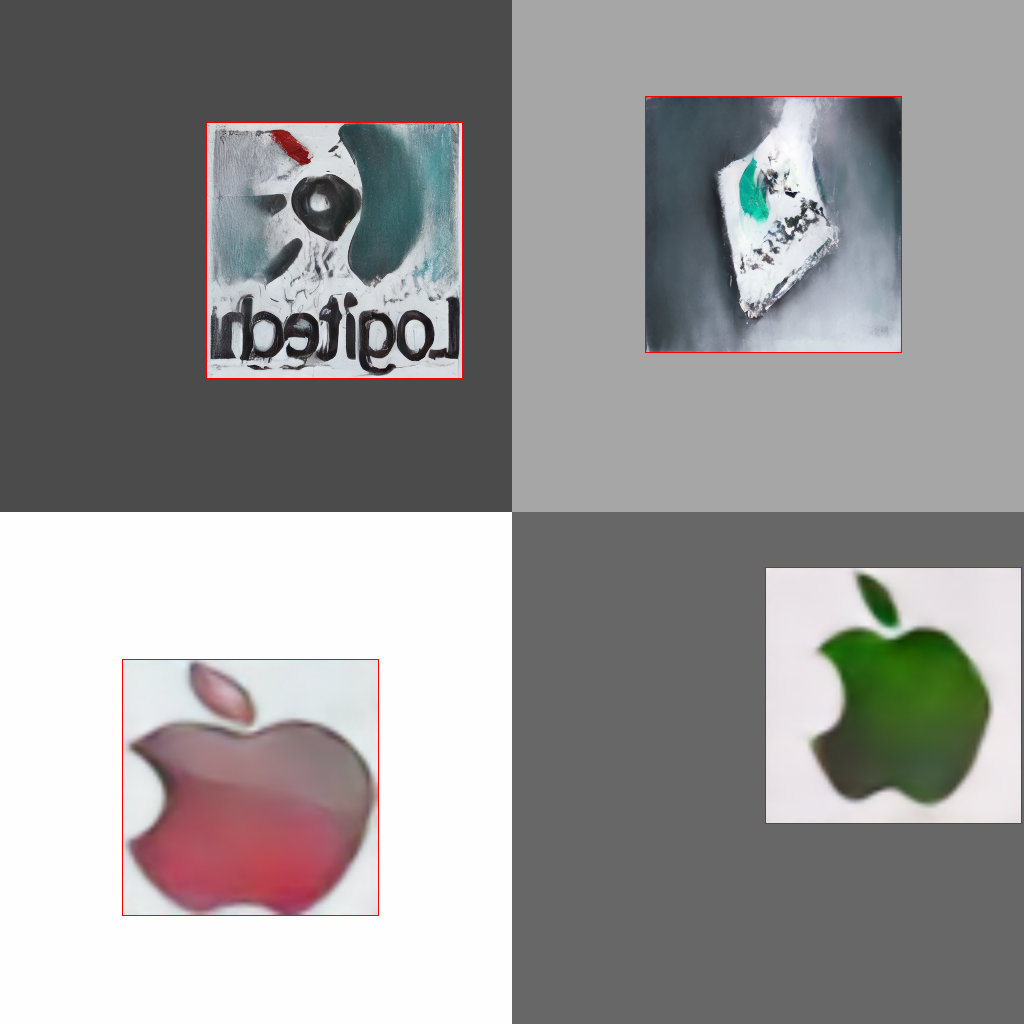

In [148]:
myFig(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB), label_list)

In [152]:
result_image.shape

(1024, 1024, 3)

In [ ]:
갤러리아이디 존재할때
    json_dict = {'labelId':label_name,'modelId':'4','galleryId':t_model_id,'count':len(label_file_list)}
아닐때
    json_dict = {'labelId':label_name,'modelId':t_model_id,'count':len(label_file_list)}